In [13]:
suppressPackageStartupMessages(library(dplyr)) 
library(ggplot2)
library(pheatmap)
library(Matrix)
library(RColorBrewer)
suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(Signac))
source("~/scratch/28.FC_16k_Droplet_PT_221210/05.R/DPT_help.R") ### helper code

In [2]:
getwd()
subdir <- "."

[1] "/oasis/tscc/scratch/y2xie/28.FC_16k_Droplet_PT_221210/05.R/Preprocess"

# Bulk peaks calling:
### snATACutils_peaks_calling.sh
### merge peaks from each replicates with snATACutils_peaks_overlap.sh

### Compare number of peaks called: Droplet Paired-Tag and Paired-Tag

In [7]:
k27ac_peaks <- "/home/y2xie/scratch/28.FC_16k_Droplet_PT_221210/09.macs2/DNA_cluster/corrected/rep_merged/FC_H3K27ac_clusters_replicates_merged.filteredNfixed.union.bed"
PT_k27ac_peaks <- "/home/y2xie/scratch/public_data/13.Paired-Tag/09.macs2/corrected/rep_merged/PT_H3K27ac_psr_2rep.filterNfixed.maskBL.bed" ### pseudoreplicates
cemba <- "/home/y2xie/scratch/28.FC_16k_Droplet_PT_221210/annotation/aggregated_maskBL.cCRE.bed"

k27ac_number <- system(paste0("wc -l ", k27ac_peaks), intern = T)
PT_k27ac_number <- system(paste0("wc -l ", PT_k27ac_peaks), intern = T)
cemba_number <- system(paste0("wc -l ", cemba), intern = T)
k27ac_number <- stringr::str_split_fixed(k27ac_number, pattern = " ", n = 2)[,1] %>% as.integer
PT_k27ac_number <- stringr::str_split_fixed(PT_k27ac_number, pattern = " ", n = 2)[,1] %>% as.integer
cemba_number <- stringr::str_split_fixed(cemba_number, pattern = " ", n = 2)[,1] %>% as.integer

intersect12 <- system(paste0("bedtools intersect -a ", k27ac_peaks, " -b ", cemba, " | wc -l"), intern = T) %>% as.integer
intersect32 <- system(paste0("bedtools intersect -a ", PT_k27ac_peaks, " -b ", cemba, " | wc -l"), intern = T) %>% as.integer
intersect13 <- system(paste0("bedtools intersect -a ", k27ac_peaks, " -b ", PT_k27ac_peaks, " | wc -l"), intern = T) %>% as.integer
intersect123 <- system(paste0("bedtools intersect -a ", k27ac_peaks, " -b ", cemba, " | bedtools intersect -a stdin -b ", 
                              PT_k27ac_peaks, " | wc -l"), intern = T) %>% as.integer

In [8]:
### Peaks from Droplet Paired-Tag
k27ac_number
### Peaks from Paired-Tag
PT_k27ac_number
### CEMBA cCREs
cemba_number

[1] 63799

[1] 27522

[1] 363731

In [9]:
### % Droplet Paired-Tag peaks in cemba
as.integer(intersect12) / as.integer(k27ac_number)

### % Paired-Tag peaks in cemba
as.integer(intersect32) / as.integer(PT_k27ac_number)

[1] 0.9078199

[1] 0.8047017

# Generate matrix based on cemba cCREs
This is to allow better comparasion between Droplet paired-Tag and the original Paired-Tag dataset

In [ ]:
### generate cell by cCREs matrix
peaks <- read.table("/home/y2xie/scratch/28.FC_16k_Droplet_PT_221210/annotation/aggregated_maskBL.cCRE.bed") 
colnames(peaks) <- c("chr", "start", "end", "name")
peaks <- makeGRangesFromDataFrame(peaks)

for (f in c("H3K27ac", "H3K27me3")){
    frags <- CreateFragmentObject(paste0(path, "03.mapping/", "FC_", f, "_merged_fragments.tsv.gz"))
    obj <- FeatureMatrix(frags, peaks, sep = c("-", "-"), verbose = TRUE)
    saveRDS(obj, paste0("FC_", f, "_CEMBA_cCRE.mtx.rds")) 
}

### H3K27ac


In [10]:
p1 <- readRDS("FC_H3K27acCEMBA_cCRE.mtx.rds")
p1 <- CreateChromatinAssay(counts = p1, sep = c("-", "-"), genome = "mm10", min.cells = 10, min.features = 10, 
                             fragments = paste0(path, "03.mapping/FC_H3K27ac_merged_fragments.tsv.gz"))
p1 <- CreateSeuratObject(p1, assay = "cemba")
p1 <- subset(p1, cells = colnames(d1))
p1 <- AddMetaData(p1, metadata = d1@meta.data, col.name = colnames(d1@meta.data))
p1
saveRDS(p1, "FC_H3K27acCEMBA_cCRE.rds")

An object of class Seurat 
317320 features across 18076 samples within 1 assay 
Active assay: cemba (317320 features, 0 variable features)

In [14]:
### RPKM filter
p1 <- subset(p1, subset = RNA_keep_cells != "False" & DNA_keep_cells == "True")
meta <- p1@meta.data[, c("nCount_DNA", "nFeature_DNA", "rna_Anno0.8")] %>% 
setNames(c("nCount_histone", "nFeature_histone", "rna_Anno0.8"))
group.by <- "rna_Anno0.8"
obj_mtx <- p1[["cemba"]]@counts

colnames(obj_mtx) <- meta[colnames(obj_mtx), "rna_Anno0.8"]
obj_mtx <- as(obj_mtx, "dgTMatrix")
obj_mtx_collapse <- OP2(obj_mtx)
cat("check obj_mtx_collapse: ", length(colnames(obj_mtx_collapse)), 
    "\n")
spars <- length(obj_mtx_collapse@x)/obj_mtx_collapse@Dim[1]/obj_mtx_collapse@Dim[2]
cat(paste0("sparsity: ", spars, "\n"))
if (spars > 0.2) {
    obj_mtx_collapse <- as(obj_mtx_collapse, "matrix")
    cat("coarse dgTMatrix into Matrix.\n")
}
length <- read.table(file = "/home/y2xie/scratch/28.FC_16k_Droplet_PT_221210/annotation/aggregated_maskBL.cCRE.bed", header = F)
length <- length %>% setNames(c("chr", "start", "end", "gene_id"))
length$length <- length$end - length$start
length$gname <- paste0(length$chr, "-", length$start, "-", length$end)
len_mtx <- as.data.frame(length[match(rownames(obj_mtx_collapse), length[, "gname"]), ])
readSums <- aggregate(meta$nCount_histone, list(meta[, group.by]), sum)
colnames(readSums) <- c("tmp", "sums")
readSums <- setNames(as.numeric(readSums$sums), readSums$tmp)
cat("check readSums: ", length(names(readSums)), "\n")
cat("check obj_mtx_collapse: ", length(colnames(obj_mtx_collapse)), 
    "\n")
readSums <- readSums[order(match(names(readSums), colnames(obj_mtx_collapse)))]
obj_collapse_XPM <- t(t(obj_mtx_collapse) * 10^9/readSums)/len_mtx$length

### select RPKM > 1 in at least one cluster
idx <- which(apply(obj_collapse_XPM, MARGIN = 1, max) > 1)
### how many?
length(idx)

check obj_mtx_collapse:  20 
sparsity: 0.656728381444599
coarse dgTMatrix into Matrix.
check readSums:  20 
check obj_mtx_collapse:  20 


[1] 311508

In [16]:
### read in Paired-tag RPKM matrix
### select RPKM > 1 in at least one cluster
pt_obj_collapse_XPM <- readRDS("~/scratch/public_data/13.Paired-Tag/05.R/seurat_object/PT_H3K27ac_CEMBA_cCRE_by_annotation.mtx.rds")
idy <- which(apply(pt_obj_collapse_XPM, MARGIN = 1, max) > 1)
### how many??
length(idy)

### intersect both: how many???
common <- intersect(rownames(obj_collapse_XPM[idx,]), rownames(pt_obj_collapse_XPM[idy,]))
length(common)

[1] 319695

[1] 289437

In [ ]:
saveRDS(obj_collapse_XPM, "FC_H3K27ac_CEMBA_cCRE_by_annotation.mtx.rds")
write.table(common, "FC_H3K27ac_DPT_PT_cemba_ovlp_cembaPeaks_RPKM1.txt", row.names = F, col.names = F, sep = "\t", quote = F)

In [ ]:
### For NMF
write.table(obj_collapse_XPM[common,], "NMF_peaks_genes/H3K27ac_CEMBA_cCRE/predicted_CRE_cluster.tsv")

### H3K27me3

In [11]:
p2 <- readRDS("FC_H3K27me3CEMBA_cCRE.mtx.rds")
p2 <- CreateChromatinAssay(counts = p2, sep = c("-", "-"), genome = "mm10", min.cells = 10, min.features = 10,
                             fragments = paste0(path, "03.mapping/FC_H3K27me3_merged_fragments.tsv.gz"))
p2 <- CreateSeuratObject(p2, assay = "cemba")
p2 <- subset(p2, cells = colnames(d2))
p2 <- AddMetaData(p2, metadata = d2@meta.data, col.name = colnames(d2@meta.data))
p2
saveRDS(p2, "FC_H3K27me3CEMBA_cCRE.rds")

An object of class Seurat 
181867 features across 15522 samples within 1 assay 
Active assay: cemba (181867 features, 0 variable features)

In [17]:
p2 <- subset(p2, subset = RNA_keep_cells != "False" & DNA_keep_cells == "True")
meta <- p2@meta.data[, c("nCount_DNA", "nFeature_DNA", "rna_Anno0.8")] %>% 
setNames(c("nCount_histone", "nFeature_histone", "rna_Anno0.8"))
group.by <- "rna_Anno0.8"
obj_mtx <- p2[["cemba"]]@counts

colnames(obj_mtx) <- meta[colnames(obj_mtx), group.by]
obj_mtx <- as(obj_mtx, "dgTMatrix")
obj_mtx_collapse <- OP2(obj_mtx)
cat("check obj_mtx_collapse: ", length(colnames(obj_mtx_collapse)), 
    "\n")
spars <- length(obj_mtx_collapse@x)/obj_mtx_collapse@Dim[1]/obj_mtx_collapse@Dim[2]
cat(paste0("sparsity: ", spars, "\n"))
if (spars > 0.2) {
    obj_mtx_collapse <- as(obj_mtx_collapse, "matrix")
    cat("coarse dgTMatrix into Matrix.\n")
}
length <- read.table(file = "/home/y2xie/scratch/28.FC_16k_Droplet_PT_221210/annotation/aggregated_maskBL.cCRE.bed", header = F)
length <- length %>% setNames(c("chr", "start", "end", "gene_id"))
length$length <- length$end - length$start
length$gname <- paste0(length$chr, "-", length$start, "-", length$end)
len_mtx <- as.data.frame(length[match(rownames(obj_mtx_collapse), length[, "gname"]), ])
readSums <- aggregate(meta$nCount_histone, list(meta[, group.by]), sum)
colnames(readSums) <- c("tmp", "sums")
readSums <- setNames(as.numeric(readSums$sums), readSums$tmp)
cat("check readSums: ", length(names(readSums)), "\n")
cat("check obj_mtx_collapse: ", length(colnames(obj_mtx_collapse)), 
    "\n")
readSums <- readSums[order(match(names(readSums), colnames(obj_mtx_collapse)))]
obj_collapse_XPM <- t(t(obj_mtx_collapse) * 10^9/readSums)/len_mtx$length
### ?
idx <- which(apply(obj_collapse_XPM, MARGIN = 1, max) > 1)

pt_obj_collapse_XPM <- readRDS("~/scratch/public_data/13.Paired-Tag/05.R/seurat_object/PT_H3K27me3_CEMBA_cCRE_by_annotation.mtx.rds")
### ??
idy <- which(apply(pt_obj_collapse_XPM, MARGIN = 1, max) > 1)

common2 <- intersect(rownames(obj_collapse_XPM[idx,]), rownames(pt_obj_collapse_XPM[idy,]))
### ???
length(common2)

check obj_mtx_collapse:  20 
sparsity: 0.452587055375632
coarse dgTMatrix into Matrix.
check readSums:  20 
check obj_mtx_collapse:  20 


[1] 127005

In [ ]:
saveRDS(obj_collapse_XPM, "FC_H3K27me3_CEMBA_cCRE_by_annotation.mtx.rds")
write.table(common2, "FC_H3K27me3_DPT_PT_cemba_ovlp_cembaPeaks_RPKM1.txt", row.names = F, col.names = F, sep = "\t", quote = F)

In [ ]:
### For NMF
write.table(obj_collapse_XPM[common2,], "NMF_peaks_genes/H3K27me3_CEMBA_cCRE/predicted_CRE_cluster.tsv")

# Classify peaks into module:
### runNMF.sh

In [19]:
d1peaks <- read.table("NMF_peaks_genes/H3K27ac_CEMBA_cCRE/predicted_CRE_cluster.tsv", row.names = 1, header = T)
d2peaks <- read.table("NMF_peaks_genes/H3K27me3_CEMBA_cCRE/predicted_CRE_cluster.tsv", row.names = 1, header = T)

d1peaks_filt1 <- d1peaks[apply(d1peaks, MARGIN = 1, FUN = max) > 1,] ### filter
d2peaks_filt1 <- d2peaks[apply(d2peaks, MARGIN = 1, FUN = max) > 0.5,] ### filter

dim(d1peaks)
dim(d1peaks_filt1)

dim(d2peaks)
dim(d2peaks_filt1)

[1] 289437     20

[1] 289437     20

[1] 127005     20

[1] 127005     20

### H3K27ac: sort and order


Warning message:
“package ‘viridis’ was built under R version 4.1.3”


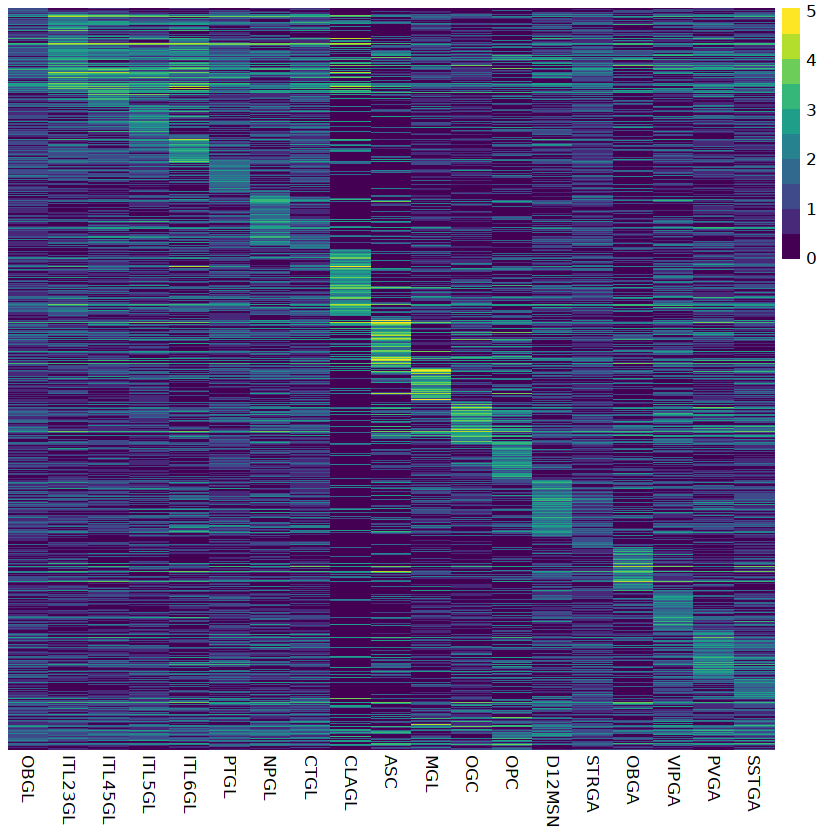

In [20]:
k27ac_nmf <- read.table("NMF_peaks_genes/H3K27ac_CEMBA_cCRE//res/predicted_CRE_cluster.r20n10.statW", 
                        row.names = 1, header = F)
colnames(k27ac_nmf) <- c("index","class0","contributes","fs","selt_fs_list","selt_med_list")
k27ac_nmf_name <- read.table("../NMF_peaks_genes/H3K27ac_CEMBA_cCRE/res/predicted_CRE_cluster.r20n10.statH", 
                        row.names = 1, header = F)
colnames(k27ac_nmf_name) <- c("index","class0","class1","contributes","sparseness","entropy")
corder <- k27ac_nmf %>% dplyr::arrange(class0) %>% rownames
rorder <- k27ac_nmf_name %>% dplyr::filter(rownames(k27ac_nmf_name) != "VLMC") %>% dplyr::arrange(class0) %>% rownames

### plot
plot <- d1peaks_filt1
plot[plot > 32] <- 32
suppressPackageStartupMessages(library(viridis))
### manual ordering
rorder <- c("OBGL", "ITL23GL", "ITL45GL", "ITL5GL", "ITL6GL", "PTGL", "NPGL", "CTGL", "CLAGL", 
            "ASC", "MGL", "OGC", "OPC", "D12MSN", "STRGA", "OBGA", "VIPGA", "PVGA", "SSTGA") # "VLMC"
corder <- k27ac_nmf %>% 
mutate(class0 = factor(class0, levels = k27ac_nmf_name[rorder, "class0"])) %>% dplyr::arrange(class0) %>% rownames
t1 <- log2(plot[corder, rorder]+1) %>%
pheatmap(cluster_rows = F, cluster_cols = F, 
         color = viridis(10), show_rownames = FALSE)

### H3K27me3: sort and order

[1] 127005      6

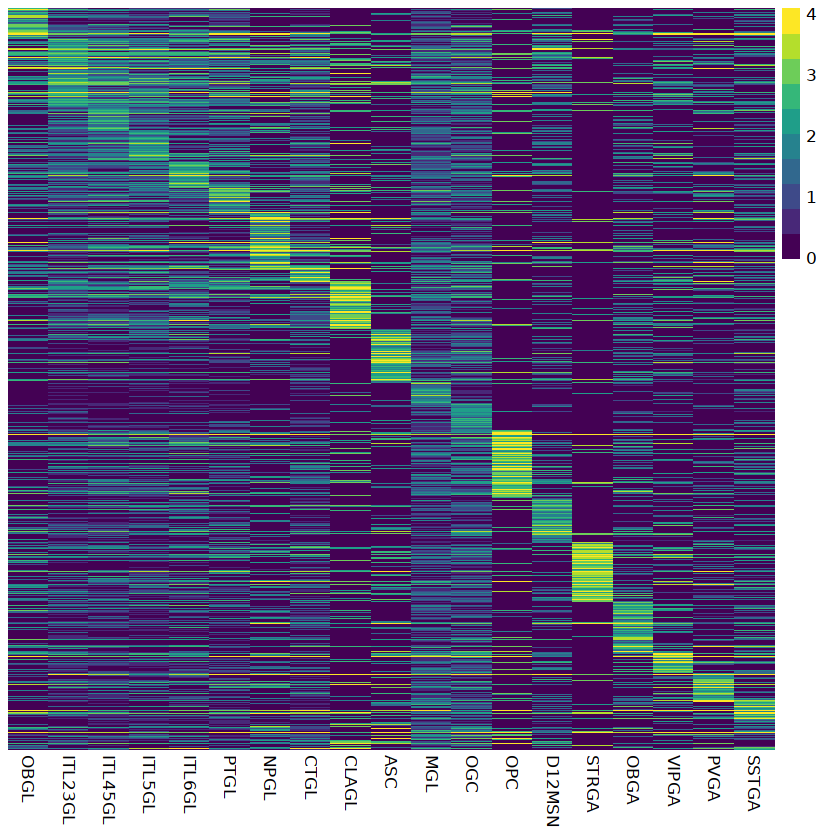

In [21]:
k27me3_nmf <- read.table("NMF_peaks_genes/H3K27me3_CEMBA_cCRE//res/predicted_CRE_cluster.r20n10.statW", 
                        row.names = 1, header = F)
colnames(k27me3_nmf) <- c("index","class0","contributes","fs","selt_fs_list","selt_med_list")
k27me3_nmf_name <- read.table("NMF_peaks_genes/H3K27me3_CEMBA_cCRE//res/predicted_CRE_cluster.r20n10.statH", 
                        row.names = 1, header = F)
colnames(k27me3_nmf_name) <- c("index","class0","class1","contributes","sparseness","entropy")
dim(k27me3_nmf)
corder <- k27me3_nmf %>% dplyr::arrange(class0) %>% rownames
order <- c("OBGL", "ITL23GL", "ITL45GL", "ITL5GL", "ITL6GL", "PTGL", "NPGL", "CTGL", "CLAGL", 
            "ASC", "MGL", "OGC", "OPC", "D12MSN", "STRGA", "OBGA", "VIPGA", "PVGA", "SSTGA") # "VLMC"
corder <- k27me3_nmf %>% 
mutate(class0 = factor(class0, levels = k27me3_nmf_name[rorder, "class0"])) %>% 
dplyr::arrange(class0) %>% rownames

plot <- d2peaks_filt1
plot[plot > 16] <- 16

t1 <- log2(plot[corder, rorder]+1) %>%
pheatmap(cluster_rows = F, cluster_cols = F, 
         color = viridis(10), show_rownames = FALSE)

## Only plot intersection of H3K27ac and H3K27me3

In [22]:
share <- intersect(rownames(d2peaks_filt1), rownames(d1peaks_filt1))
length(share)
d1peaks_filt2 <- d1peaks_filt1[share, ]
d2peaks_filt2 <- d2peaks_filt1[share, ]

[1] 108319

## separate promoter proximal and distal CRE

In [23]:
cre_bed <- stringr::str_split_fixed(share, pattern = "-", n = 3) %>% as.data.frame
cre_gr <- GenomicRanges::GRanges(cre_bed[, 1], IRanges::IRanges(as.integer(cre_bed[, 2]), as.integer(cre_bed[, 3])))
tss <- read.table("/projects/ps-renlab/y2xie/projects/genome_ref/mm10.tss.vm25.2k.bed", header = F)
tss_gr <- GenomicRanges::GRanges(tss[, 1], IRanges::IRanges(tss[, 2], tss[, 3])) 
idy = S4Vectors::queryHits(GenomicRanges::findOverlaps(cre_gr, tss_gr))
idy <- idy %>% unique

### distal cCREs

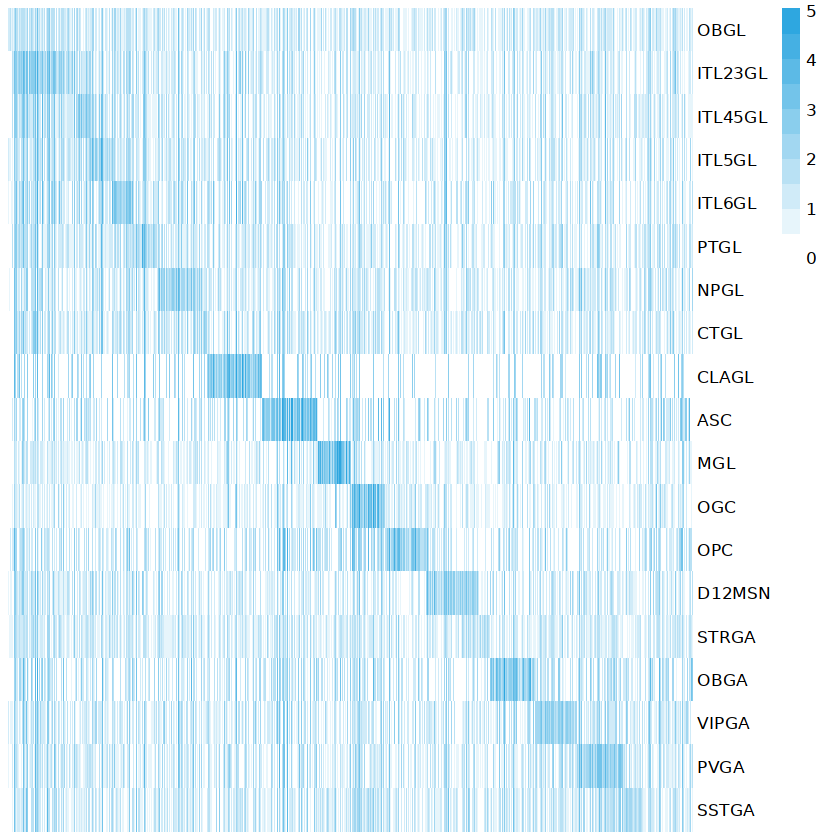

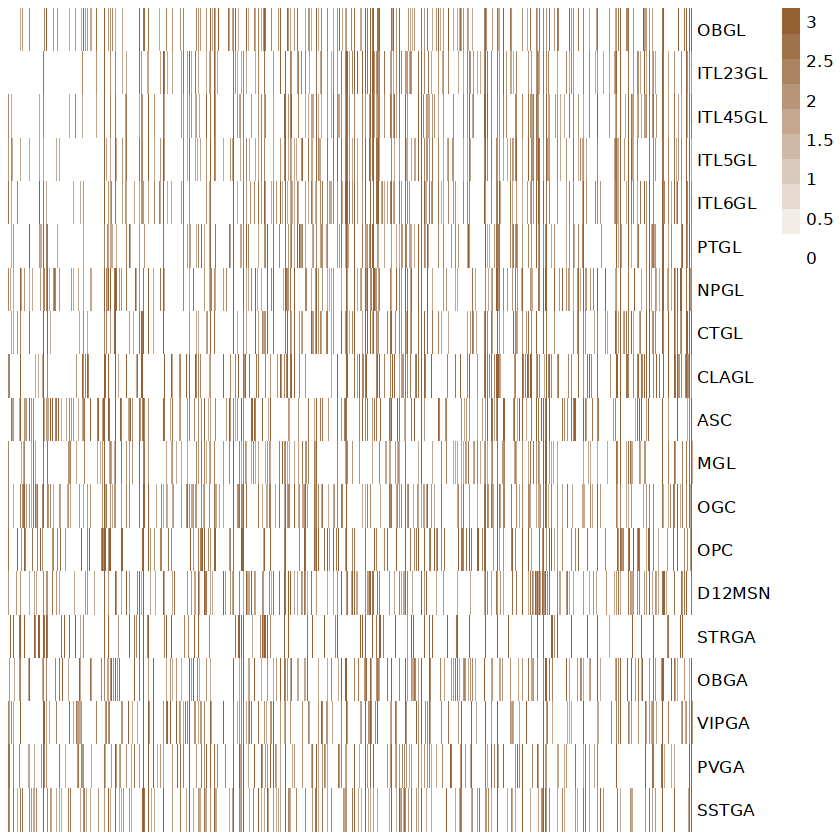

In [25]:
rorder <- c("OBGL", "ITL23GL", "ITL45GL", "ITL5GL", "ITL6GL", "PTGL", "NPGL", "CTGL", "CLAGL", 
            "ASC", "MGL", "OGC", "OPC", "D12MSN", "STRGA", "OBGA", "VIPGA", "PVGA", "SSTGA") # "VLMC"
distal <- share[-idy]
d1peaks_filt3 <- d1peaks_filt1[rownames(d1peaks_filt1) %in% distal, ]
d2peaks_filt3 <- d2peaks_filt1[rownames(d2peaks_filt1) %in% distal, ]

plot <- d1peaks_filt3
plot[plot > 32] <- 32

corder <- k27ac_nmf[rownames(k27ac_nmf) %in% rownames(d1peaks_filt3), ] %>% 
mutate(class0 = factor(class0, levels = k27ac_nmf_name[rorder, "class0"])) %>% 
dplyr::arrange(class0) %>%
rownames

t1 <- log2(plot[corder, rorder]+1) %>% t %>%
pheatmap(cluster_rows = F, cluster_cols = F, show_rownames = T, show_colnames = F,
         color = colorRampPalette(c("white", "#2EA7E0"))(10))

plot1 <- d2peaks_filt3
plot1[plot1 > 8] <- 8
plot1[plot1 < 2] <- 0
t2 <- log2(plot1[corder, rorder]+1) %>% t %>%
pheatmap(cluster_rows = F, cluster_cols = F,  show_rownames = T, show_colnames = F,
          color = colorRampPalette(c("white", "#956134"))(10))


### Proximal cCREs

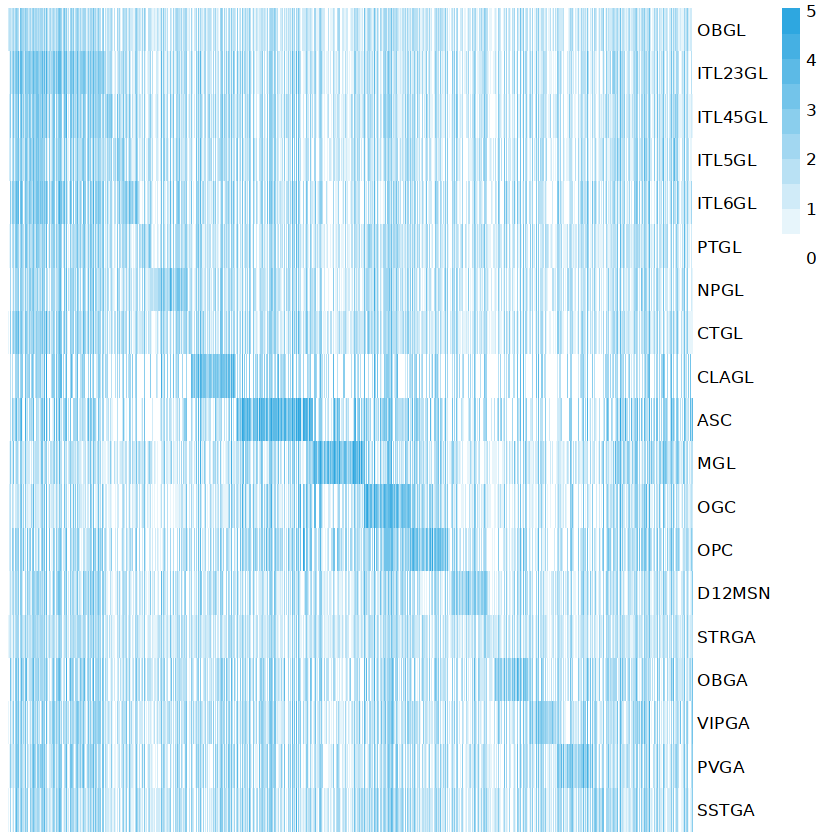

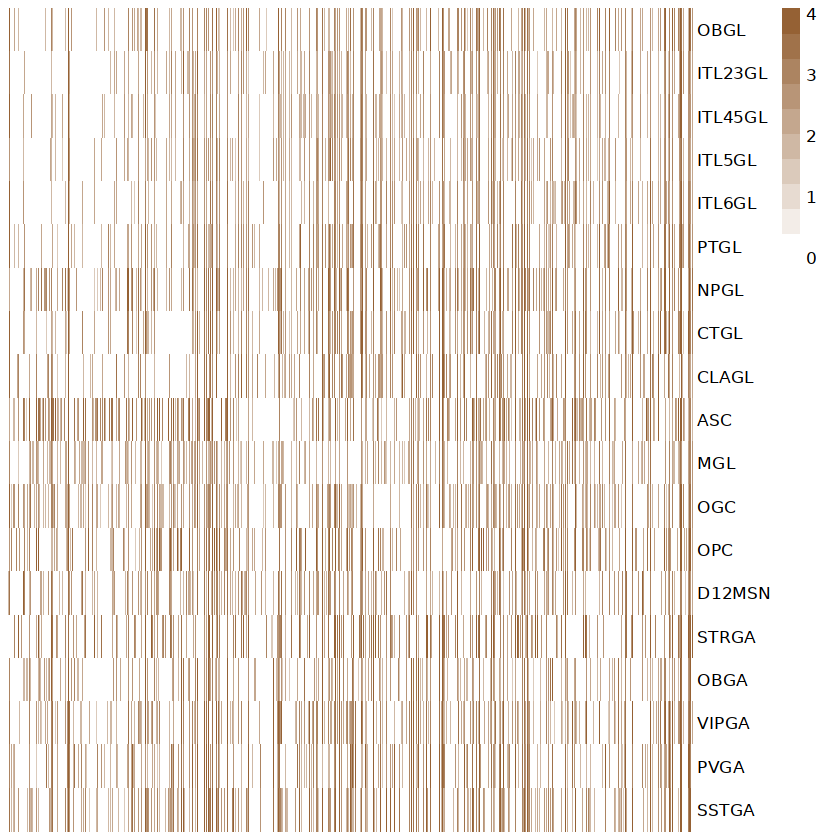

In [27]:
proximal <- share[idy]
d1peaks_filt3 <- d1peaks_filt1[rownames(d1peaks_filt1) %in% proximal, ]
d2peaks_filt3 <- d2peaks_filt1[rownames(d2peaks_filt1) %in% proximal, ]
# share2 <- intersect(share, proximal)
# d1peaks_filt3 <- d1peaks_filt1[share2, ]
# d2peaks_filt3 <- d2peaks_filt1[share2, ]

plot <- d1peaks_filt3
plot[plot > 32] <- 32

corder <- k27ac_nmf[rownames(k27ac_nmf) %in% rownames(d1peaks_filt3), ] %>% 
mutate(class0 = factor(class0, levels = k27ac_nmf_name[rorder, "class0"])) %>% 
dplyr::arrange(class0) %>%
rownames

t1 <- log2(plot[corder, rorder]+1) %>% t %>%
pheatmap(cluster_rows = F, cluster_cols = F, show_rownames = T, show_colnames = F, 
         color = colorRampPalette(c("white", "#2EA7E0"))(10))

plot1 <- d2peaks_filt3
plot1[plot1 > 16] <- 16
plot1[plot1 < 2] <- 0
t2 <- log2(plot1[corder, rorder]+1) %>% t %>%
pheatmap(cluster_rows = F, cluster_cols = F, show_rownames = T, show_colnames = F, 
          color = colorRampPalette(c("white", "#956134"))(10))


### RNA for proximal cCREs

In [28]:
p_bed <- stringr::str_split_fixed(proximal, pattern = "-", n = 3) %>% as.data.frame
write.table(p_bed, "tmp.bed", row.names = F, col.names = F, sep = "\t", quote = F)
system("bedtools intersect -a tmp.bed -b /projects/ps-renlab/y2xie/projects/genome_ref/mm10.tss.vm25.2k.bed -wo > tmp.tss.bed")
p_bed_tss <- read.table("tmp.tss.bed", header = F)
gtp_df <- p_bed_tss[,c(1:3,9)] %>% setNames(c("chr1", "start1", "end1", "gene")) %>% 
mutate(proximal = paste(chr1, start1, end1, sep = "-")) %>% 
dplyr::select(c("gene", "proximal"))

sparsity: 0.566880904444789
coarse dgTMatrix into Matrix.
check readSums:  20 
check obj_mtx_collapse:  20 


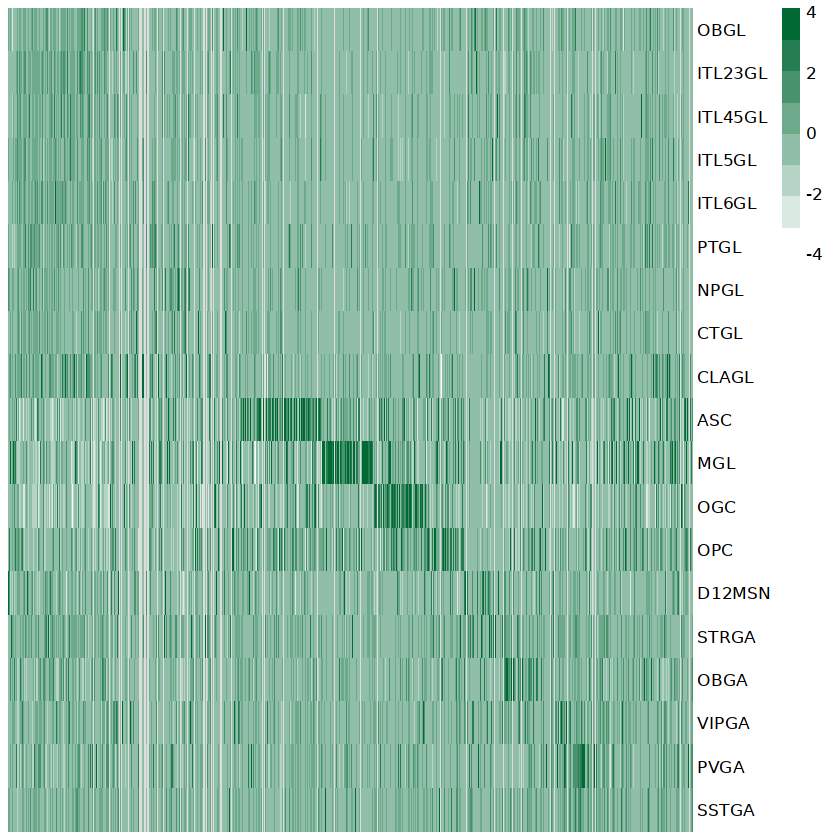

In [30]:
mmg <- readRDS("FC_RNA_Seurat_merged_rmScrublet.rds")
rna <- subset(mmg, subset = RNA_keep_cells == "True")
rmeta <- rna@meta.data[,c("nCount_RNA", "Anno0.8_yel")]
rna <- ArcXPM(rna[["RNA"]]@counts, meta = rmeta, group.by = "Anno0.8_yel", method = "RPKM")

gorder <- unique(gtp_df[match(corder, gtp_df$proximal), "gene"])
gorder <- intersect(gorder, rownames(rna))

plot <- rna
cutoff1 <- quantile(plot, probs = 0.05, na.rm = T)
cutoff2 <- quantile(plot, probs = 0.99, na.rm = T)
plot[plot < cutoff1] <- cutoff1
plot[plot > cutoff2] <- cutoff2

t1 <- log2(plot[gorder, rorder]+1) %>% t %>%
pheatmap(scale = "column", cluster_rows = F, cluster_cols = F, show_rownames = T, show_colnames = F, 
         color = colorRampPalette(c("white", "#006934"))(8))

## Plot known motif heatmap

### Distal cCREs

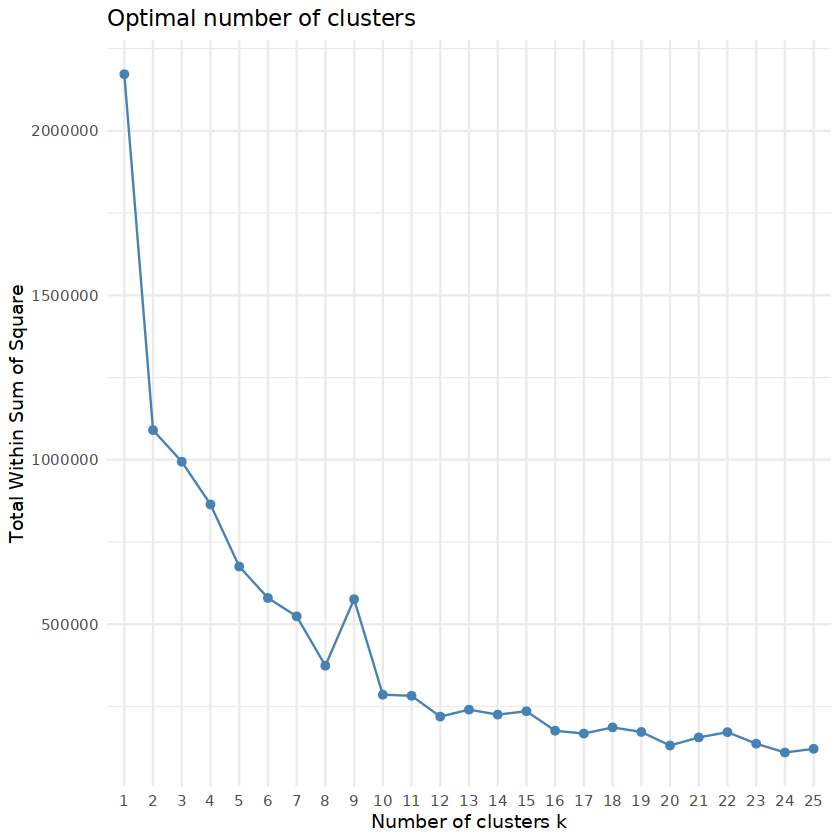

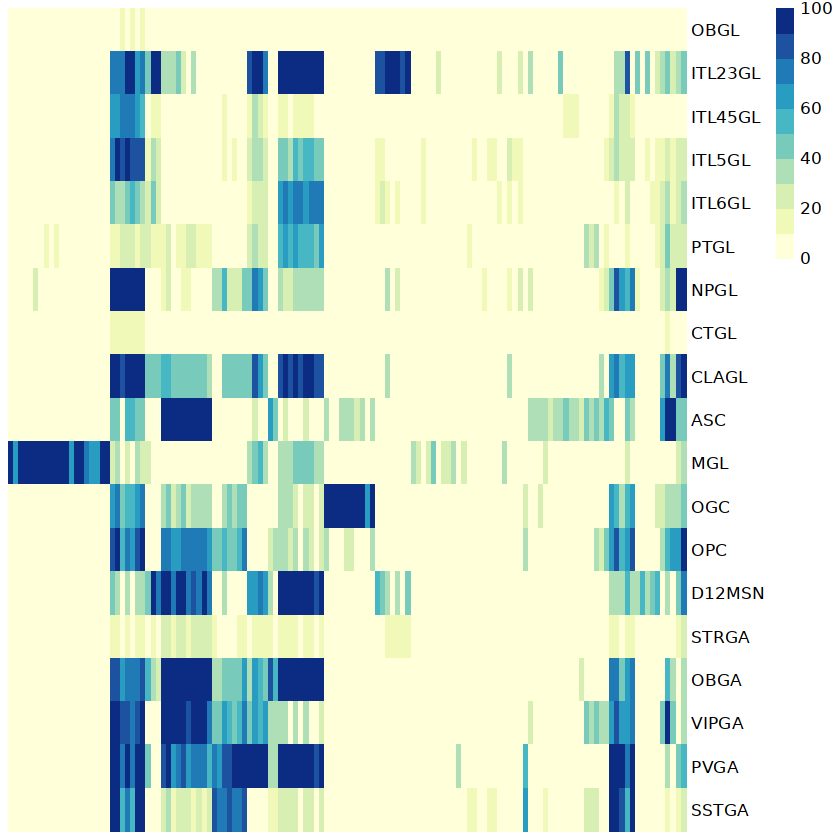

In [33]:
motifp <- list()
inpath <- "/home/y2xie/scratch/28.FC_16k_Droplet_PT_221210/05.R/homer/CEMBA_cCRE/cluster_specific_peaks_distal/"
for (f in list.files(path = inpath, pattern = ".*_cCRE$")){
    fname <- sub("_cCRE$", "", f)
    motif <- read.csv(paste0(inpath, f, "/knownResults.txt"), header = T, sep = "\t")
    motif <- motif[, 1:5] %>% setNames(c("motif", "Consensus", "p_value", "log10pval", "p_adj"))
    motif$sample <- fname
    motif$log10pval <- -log10(motif$p_value)
    motifp[[fname]] <- motif
}

motifp <- do.call(rbind, motifp)

### plot top 50? 
rorder <- c("OBGL", "ITL23GL", "ITL45GL", "ITL5GL", "ITL6GL", "PTGL", "NPGL", "CTGL", "CLAGL", 
            "ASC", "MGL", "OGC", "OPC", "D12MSN", "STRGA", "OBGA", "VIPGA", "PVGA", "SSTGA")
motifpheat1 <- motifp %>%
dplyr::filter(sample %in% grep("H3K27ac", unique(motifp$sample), value = T)) %>%
mutate(sample = sub("_H3K27ac$", "", sample)) %>%
group_by(sample) %>%
mutate(sample = factor(sample, levels = c(rorder, "VLMC"))) %>%
slice_max(order_by = log10pval, n = 50) 

motifpheat2 <- motifpheat1 %>%
reshape2::dcast(motif ~ sample, fill = 0, value.var = "log10pval", fun.aggregate = max) %>%
tibble::column_to_rownames("motif")

motifpheat2 <- motifpheat2 %>% ### filter!
dplyr::filter(rowMeans(motifpheat2) > 1)
motifpheat2[motifpheat2 > 100] <- 100 

### kmeans ordering
set.seed(921)
factoextra::fviz_nbclust(motifpheat2, kmeans, method = "wss", k.max = 25) + 
theme_minimal()
### 17 clusters
k1 <- kmeans(motifpheat2, centers = 17, nstart = 30)

### motif order
korder <- k1$cluster %>% order
kordern <- k1$cluster[korder] %>% names

t1 <- motifpheat2[kordern, rorder] %>% t %>%
pheatmap(cluster_cols = F, cluster_rows = F,
         show_rownames = T, show_colnames = F, border_color = NA,
        color = colorRampPalette((brewer.pal(n = 8, name = "YlGnBu")))(10))

### Proximal cCREs


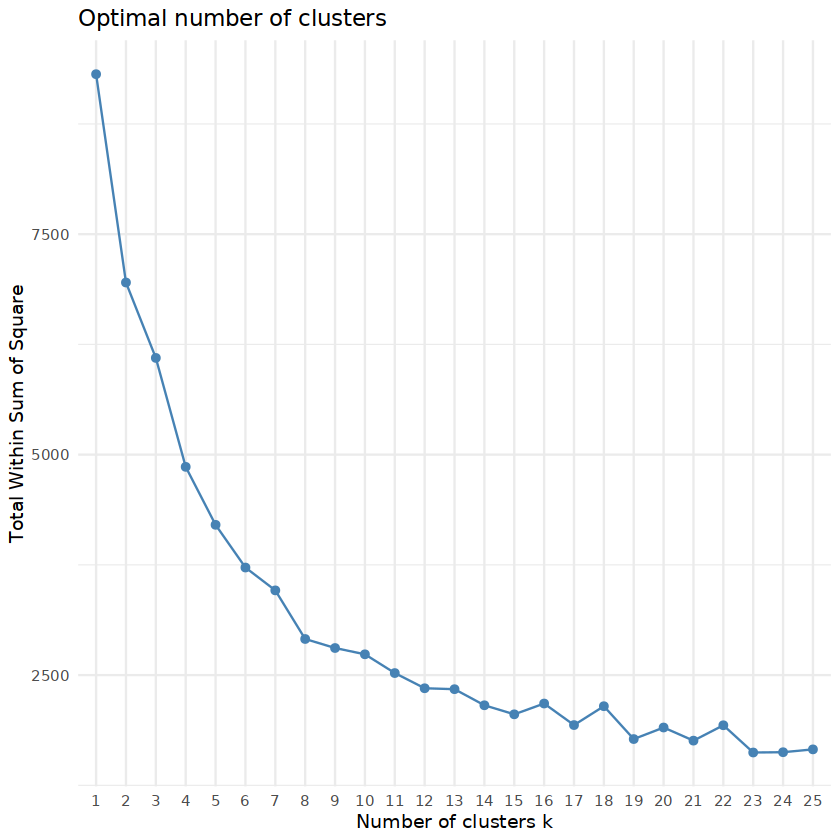

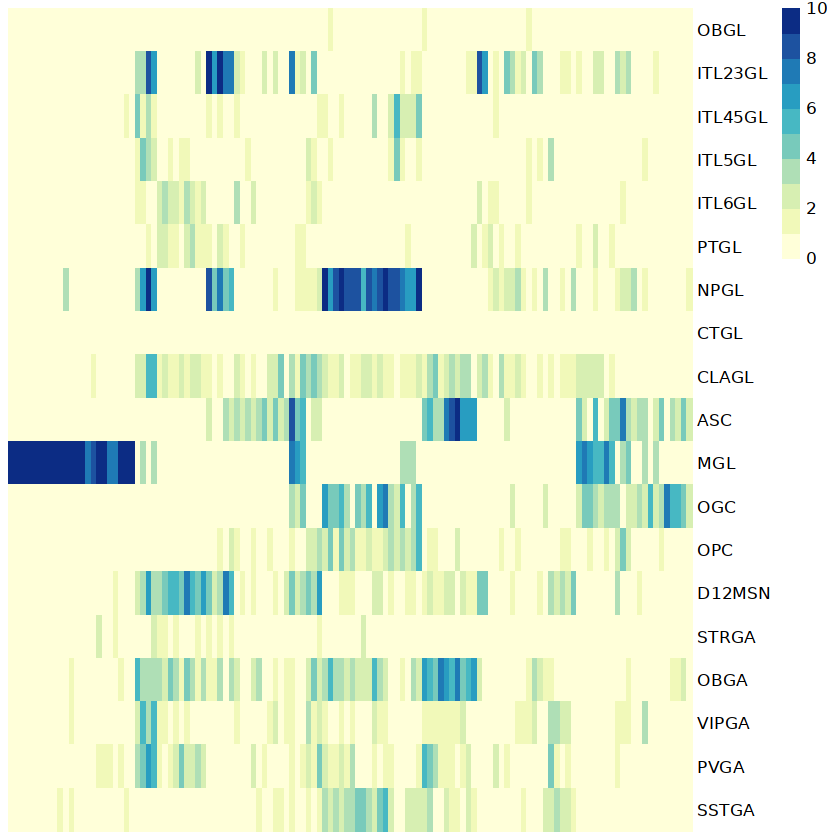

In [35]:
motifp1 <- list()
inpath <- "/home/y2xie/scratch/28.FC_16k_Droplet_PT_221210/05.R/homer/CEMBA_cCRE/cluster_specific_peaks_proximal/"
for (f in list.files(path = inpath, pattern = ".*_cCRE$")){
    fname <- sub("_cCRE$", "", f)
    motif <- read.csv(paste0(inpath, f, "/knownResults.txt"), header = T, sep = "\t")
    motif <- motif[, 1:5] %>% setNames(c("motif", "Consensus", "p_value", "log_p_value", "p_adj"))
    motif$sample <- fname
    motif$log10pval <- -log10(motif$p_value)
    motifp1[[fname]] <- motif
}

motifp1 <- do.call(rbind, motifp1)

motifpheat1 <- motifp1 %>%
dplyr::filter(sample %in% grep("H3K27ac", unique(motifp$sample), value = T)) %>%
mutate(sample = sub("_H3K27ac$", "", sample)) %>%
group_by(sample) %>%
mutate(sample = factor(sample, levels = c(rorder, "VLMC"))) %>%
slice_max(order_by = log10pval, n = 50) 

motifpheat2 <- motifpheat1 %>%
reshape2::dcast(motif ~ sample, fill = 0, value.var = "log10pval", fun.aggregate = max) %>%
tibble::column_to_rownames("motif")

motifpheat2 <- motifpheat2 %>% ### filter!
dplyr::filter(rowMeans(motifpheat2) > 0.5)
motifpheat2[motifpheat2 > 10] <- 10 

### kmeans ordering
set.seed(921)
factoextra::fviz_nbclust(motifpheat2, kmeans, method = "wss", k.max = 25) + 
theme_minimal()
### 17 clusters
k1 <- kmeans(motifpheat2, centers = 17, nstart = 30)

### motif order
korder <- k1$cluster %>% order
kordern <- k1$cluster[korder] %>% names

t1 <- motifpheat2[kordern, intersect(rorder, colnames(motifpheat2))] %>% t %>%
pheatmap(cluster_cols = F, cluster_rows = F,
         show_rownames = T, show_colnames = F, border_color = NA,
        color = colorRampPalette((brewer.pal(n = 8, name = "YlGnBu")))(10))